###**Frequency Magnitude Distribution Function**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
#import scipy.stats

class FMD:
    def __init__(self):
        self.data = { 'mag'     : np.array([]),
                      # hist and cumul distribution
                      'magBins' : np.array([]),
                      'magHist' : np.array([]),
                      'cumul'   : np.array([]),
                      }
        self.par  = {
                        'b'        : None, # float()
                        'a'        : None, # float()
                        'Mc'       : None, # float()
                        'stdDev'   : None, # uncertainty of b exponent based on N and b
                        'binsize'  : 0.1, # default value
                        }

    def error_check(self):
        if len( self.data['mag']) == 0:
            error_str = "no magnitudes assigned to self.data['mag']"
            raise ValueError( error_str)

        if self.par['Mc'] == None:
            error_str = 'Mc not found, run function getMc() first'
            raise ValueError( error_str)

    def get_Mc(self, mc_type = 'MC', **kwargs):
        N = len( self.data['mag'])
        if isinstance( mc_type, (str)):
            if mc_type == 'maxCurvature' or mc_type == 'MC':
                # MC from maximum curvature
                self.mag_dist()
                sel = ( self.data['magHist'] == self.data['magHist'].max() )
                self.par['Mc'] = self.data['magBins'][sel.T].max()
            elif mc_type ==  'KS':# use KS stats to find best-fit xmin
                self.par['Mc'] = self.Mc_KS( np.unique( self.data['mag']),  **kwargs)
            else:
                error_str = "completeness type unknown:, %s, use 'KS, float, maxCurvature (or MC) or array for KS test" %( mc_type)
                raise ValueError(  error_str)

        elif isinstance( mc_type, (float, int) ):
            self.par['Mc']      = float( mc_type )

        elif isinstance( mc_type, (np.ndarray, list) ):#use KS stats for data within min. max. values
            if np.array( mc_type).shape[0] > 2:
                self.par['Mc'] = self.Mc_KS( mc_type,  **kwargs)
            else:
                sel_mag = np.logical_and( self.data['mag']>=np.array( mc_type).min(),
                                          self.data['mag']<=np.array( mc_type).max() )
                aMc_sim = self.data['mag'][sel_mag]
                self.par['Mc'] = self.Mc_KS(  np.unique( aMc_sim),  **kwargs)
        else:
            error_str = "completeness type unknown:, %s, use 'KS, float, maxCurvature (or MC) or array for KS test" %( mc_type)
            raise ValueError( error_str)

    def mag_dist(self, **kwargs):
        if 'binsize' in kwargs.keys() and kwargs['binsize'] is not None:
            self.par['binsize'] = kwargs['binsize']
        # sort magnitudes
        self.data['mag']   = np.array( sorted( self.data['mag']))
        # cumulative distribution
        self.data['cumul'] = np.cumsum( np.ones( len( self.data['mag'])))[::-1]

        self.data['magBins'] = np.arange( round( self.data['mag'].min(), 1), self.data['mag'].max()+self.par['binsize'] , self.par['binsize'])
        self.data['magHist'], __ = np.histogram( self.data['mag'], self.data['magBins'])
        #switch to central bin instead of min, max from numpy
        self.data['magBins'] = self.data['magBins'][0:-1]+self.par['binsize']*.5

    def fit_GR(self, **kwargs):
        self.error_check()
        if 'binCorrection' in kwargs.keys() and kwargs['binCorrection'] is not None:
            binCorrection      = kwargs['binCorrection']
        else:
            binCorrection      = self.par['binsize']*0.5

        sel_Mc = self.data['mag']>=self.par['Mc']
        N      = sel_Mc.sum()
        meanMag            = self.data['mag'][sel_Mc].mean()
        self.par['b']      = ( 1 / ( self.data['mag'][sel_Mc].mean()- (self.par['Mc'] - binCorrection)) ) * np.log10( np.e )
        #                     ( 2.3 * np.sqrt((sum((vMag-meanMag)**2) ) / ( N * (N-1))) ) * bValue**2
        self.par['stdDev'] = ( 2.3 * np.sqrt((sum((self.data['mag'][sel_Mc]-meanMag)**2) ) / ( N * (N-1))) ) * self.par['b']**2
        self.par['a']      = np.log10( N) + self.par['b'] * self.par['Mc']

    def MLE_b(self, Mc, **kwargs):
        if 'binCorrection' in kwargs.keys() and kwargs['binCorrection'] is not None:
            binCorrection      = kwargs['binCorrection']
        else:
            binCorrection      = self.par['binsize']*0.5
        sel_Mc = self.data['mag'] >= Mc
        return ( 1. / ( self.data['mag'][sel_Mc].mean() - ( Mc - binCorrection)) ) * np.log10( np.e )

    def Mc_KS(self,  vMag_sim, **kwargs):
        if 'binCorrection' in kwargs.keys() and kwargs['binCorrection'] is not None:
            binCorrection      = kwargs['binCorrection']
        else:
            binCorrection      = self.par['binsize']*.5
        if 'maxErr_b' in kwargs.keys() and kwargs['maxErr_b'] is not None:
            maxErr_b  = kwargs['maxErr_b']
        else:
            maxErr_b  = .25
        #------------------------------------------------------------------------------

        sorted_Mag  = np.sort( self.data['mag'])
        vMag_sim    = np.sort( vMag_sim)
        vKS_stats   = np.zeros( vMag_sim.shape[0])
        vStd_err    = np.zeros( vMag_sim.shape[0])
        vB_sim      = np.zeros( vMag_sim.shape[0])
        i = 0

        for curr_Mc in vMag_sim:
            sel_Mc        = self.data['mag'] >= curr_Mc
            meanMag       = self.data['mag'][sel_Mc].mean()
            curr_b        = ( 1. / ( meanMag - ( curr_Mc - binCorrection)) ) * np.log10( np.e )#self.MLE_b( curr_Mc)
            vKS_stats[i]  = self.KS_D_value_PL( curr_Mc)
            sel = sorted_Mag >= curr_Mc
            N_aboveMc = sel.sum()
            if N_aboveMc > 1:
                vStd_err[i]   = ( 2.3 * np.sqrt((sum((self.data['mag'][sel_Mc]-meanMag)**2) ) / ( N_aboveMc* (N_aboveMc-1))) ) * curr_b**2
            else:
                vStd_err[i]   = 999
            vB_sim[i]     = curr_b
            i = i + 1
        # store in data dictionary to be called with self.plotKS
        self.data['a_KS']     = vKS_stats
        self.data['a_MagSim'] = vMag_sim

        if 'useAllMCs' in kwargs.keys() and kwargs['useAllMCs'] == True:
            return vMag_sim[vKS_stats == vKS_stats.min()][0]
        else:
            # select xmins alpha values below corresponding to alpha value below a certain error threshold
            sel = vStd_err < maxErr_b
            if sel.sum() > maxErr_b:
                sel2 = vKS_stats[sel] == vKS_stats[sel].min()
                return vMag_sim[sel][sel2][0]
            else:
                return np.nan

    def KS_D_value_PL(self, Mc):
        aMag_tmp = np.sort( self.data['mag'][self.data['mag']>=Mc] )
        # convert Mc and Mag to use power-law scaling
        vX_tmp   = 10**aMag_tmp
        xmin     = 10**Mc
        n        = aMag_tmp.shape[0]
        if n == 0:
            return np.inf
        else:
            alpha    = float(n) / ( np.log(vX_tmp/xmin)).sum()
            obsCumul = np.arange(n, dtype='float')/n #from 0 to ; Fn = i/n; where i=1, ..., n see e.g. wikipedia Anderson-Darling
            modCumul = 1-(xmin/vX_tmp)**alpha
            ks = (abs(obsCumul - modCumul)).max()
            return ks


    def UTSU_test(self, n1, n2, b1, b2):
        n = n1+n2
        if b1 > 0:
            b1 = -b1
        if b2 > 0:
            b2 = -b2
        dA = -2*n*np.log( n) + 2*n1*np.log( (n2*b1)/b2 + n1) + 2*n2*np.log( (n1*b2)/b1 + n2) - 2
        return np.exp(  -(dA/2) - 2)

    #==================================================================================================
    #                         randomized data
    #==================================================================================================
    def randomFMD(self, N, b, xmin, **kwargs):

        if 'binsize' in  kwargs.keys() and kwargs['binsize'] is not None:
            self.par['binsize'] = kwargs['binsize']
        #return (.5*xmin)*(1.-numpy.random.ranf(N))**( -1./(alpha-1.))+0.5
        #self.data['mag'] = (xmin - self.par['binsize']*.5) - np.log10( np.random.ranf(N))/b
        self.data['mag'] = (xmin) - np.log10( np.random.ranf(N))/b
    #==================================================================================================
    #                         plots
    #==================================================================================================
    def plotDistr(self, ax = None):
        if len( self.data['magBins']) == 0 or len( self.data['cumul']) == 0:
            error_str = 'mag bins and/or cumul empty run : self.mag_dist() first'
            raise ValueError( error_str)

        N   = len( self.data['mag'])
        if ax == None:
            plt.figure(1, figsize=(8,7))
            ax = plt.axes([.12,.126,.83,.83]) #(111)

        #___________________________ distribution___________________________________________
        ax.semilogy( self.data['magBins'], self.data['magHist'], 'ks', ms = 5, mew = 1, label = 'non cumulative')
        ax.semilogy( self.data['mag'], self.data['cumul'], 'bo', ms = 2, label='cumulative' )

        #___________________________ labels and limits------------------------------
        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Number of Events')
        ax.legend( shadow = False, numpoints=1, loc = 'upper right')#, frameon = False)
        #ax.set_xlim( self.par['Mc']-2, self.data['mag'].max()+.5)#ax.get_xlim()[1])
        ax.set_ylim(1, N*1.2)
        ax.grid('on')
        return ax

    def plotFit(self, ax):
        self.error_check()
        N   = len(self.data['mag'][self.data['mag'] >= self.par['Mc']])

        if ax == None:
            plt.figure(1, figsize=(8,7))
            ax = plt.axes([.12,.126,.83,.83]) #(111)

        #___________________________ distribution___________________________________________
        ax.semilogy(self.data['magBins'], self.data['magHist'], 'ks', ms=5, mew=1, label='non cumulative')
        sel = self.data['mag'] > self.par['Mc'] - 1 # just one below completeness for fast plotting
        ax.semilogy(self.data['mag'][sel], self.data['cumul'][sel], 'bo', ms=2, label='cumulative')

        #___________________________ plot completeness magnitude___________________________________________
        ax.plot([self.par['Mc']], [self.data['cumul'][sel][0]], 'rv', ms=10, label=f"$M_c = {round(self.par['Mc'], 1)}$, $a = {round(self.par['a'], 2)}$, $b = {round(self.par['b'], 2)}$")

        # Hitung nilai a-value (annual) dengan asumsi 48 tahun pengamatan
        a_annual = self.par['a'] - np.log10(48)

        # Tambahkan teks ke dalam plot
        ax.text(0.1, 2, f"$a$-value: {round(self.par['a'], 2)}\n$b$-value: {round(self.par['b'], 2)}\n$a$-value (annual): {round(a_annual, 2)}", fontsize=12, color='green')

        mag_hat = np.linspace(self.data['mag'].min()-2*self.par['binsize'], self.data['mag'].max()+2*self.par['binsize'], 10)
        N_hat = 10**((-self.par['b']*mag_hat) + self.par['a'])
        ax.semilogy(mag_hat, N_hat, 'r--', label='$\log(N) = -%.1f \cdot M + %.1f$' % (round(self.par['b'], 1), round(self.par['a'], 1)))

        ax.set_xlabel('Magnitude')
        ax.set_ylabel('Number of Events')
        ax.set_title('$N (M>M_c) = %.0f ; \; \sigma_b = %.3f $' % (N, self.par['stdDev']))
        ax.legend(shadow=False, numpoints=1, loc='upper right')
        ax.set_ylim(1, len(self.data['mag'])*1.2)
        ax.grid('on')
        return ax





    def plotKS(self, ax = None):
        if 'a_KS' in self.data.keys():
            if ax == None:
                plt.figure()
                ax = plt.subplot(111)

            ax.plot( self.data['a_MagSim'], self.data['a_KS'], 'b-')
            ax.set_xlabel( 'Magnitude')
            ax.set_ylabel( 'KS-D')

###**Performance Comparison of Earthquake Declustering Methods**
Earthquake Declustering Methods using Earthquake Catalog

As previously stated, preceding shocks will be classed as foreshocks for any earthquakes in the catalog of magnitude M if they occur within a particular time and space range. The earthquake with the most significant magnitude in the series is generally the primary shock. For each earthquake in the database, the following shocks are identified as aftershocks within a defined time and space window. Each declustering approach provides a mathematical formula for determining time (t) and distance (d)**bold text**.

In [2]:
dataset1 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1972-1987.csv"
dataset2 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1988-1998.csv"
dataset3 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1999-2019.csv"
dataset4 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran2020-2022.csv"
# Load each dataset
df1 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1972-1987.csv", parse_dates=['time'])
df2 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1988-1998.csv", parse_dates=['time'])
df3 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran1999-2019.csv", parse_dates=['time'])
df4 = pd.read_csv("https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Iran/Iran2020-2022.csv", parse_dates=['time'])

# Concatenate the datasets
merged_df = pd.concat([df1, df2, df3, df4], ignore_index=True) # Display the merged DataFrame merged_df.head()

####**Gardner-Knopoff**

$t = 10^{(0.032M + 2.7389)} : M \geq 6.5  $

$t = 10^{(0.5409M - 0.547)} :  M < 6.5 $

$ d = 10^{(0.1238M + 0.983)} $

In [3]:
# Read earthquake data from the provided URL
datagk = merged_df

class GardnerKnopoffType1:
    def __init__(self):
        pass

    def calculate_time(self, M):
        if M >= 6.5:
            tgk = 10**(0.032 * M + 2.7389)
        else:
            tgk = 10**(0.5409 * M - 0.547)
        return tgk

    def calculate_distance(self, M):
        dgk = 10**(0.1238 * M + 0.983)
        return dgk

# Create an instance of the declustering method
declust_methodgk = GardnerKnopoffType1()

# Calculate time and distance for each earthquake event in the dataset
datagk['time_window'] = datagk['mag'].apply(lambda x: declust_methodgk.calculate_time(x))
datagk['distance_window'] = datagk['mag'].apply(lambda x: declust_methodgk.calculate_distance(x))

# Select only the required columns
#data_selectedgk = datagk[['time', 'longitude', 'latitude', 'mag', 'magType', 'depth', 'time_window', 'distance_window']]


# Drop rows with infinity values in the selected columns
datagk = datagk.replace([np.inf, -np.inf], np.nan).dropna(subset=['time_window', 'distance_window'])

# Select only the required columns
data_selectedgk = datagk[['time', 'longitude', 'latitude', 'mag', 'magType', 'depth', 'time_window', 'distance_window']]

# Print the first few rows of the modified dataset with selected columns
data_selectedgk.head()

,time,longitude,latitude,mag,magType,depth,time_window,distance_window
0,1987-12-18 20:54:33.750000+00:00,56.683,28.239,4.6,mb,33.0,87.325283,35.684532
1,1987-12-18 16:24:03.050000+00:00,56.677,28.191,5.9,mw,19.8,440.869444,51.691603
2,1987-11-30 03:12:37+00:00,51.170,30.990,4.8,mb,37.7,112.026302,37.778090
3,1987-11-27 08:26:43.780000+00:00,59.100,32.691,4.7,mb,33.0,98.907677,36.716392
4,1987-11-25 22:53:29.970000+00:00,56.753,28.231,4.5,mb,33.0,77.099223,34.681670


In [4]:
import pandas as pd
import numpy as np

datagk = data_selectedgk

# Fungsi untuk menghitung waktu (t) berdasarkan magnitudo (M) dengan metode Gardner-Knopoff
def calculate_time_gardner_knopoff(M):
    if M >= 6.5:
        tgk = np.power(10, 0.032 * M + 2.7389)
    else:
        tgk = np.power(10, 0.5409 * M - 0.547)
    return tgk

# Fungsi untuk menghitung jarak (d) berdasarkan magnitudo (M) dengan metode Gardner-Knopoff
def calculate_distance_gardner_knopoff(M):
    dgk = np.power(10, 0.1238 * M + 0.983)
    return dgk

# Fungsi untuk mengklasifikasikan event sebagai Mainshock atau Aftershock berdasarkan metode Gardner-Knopoff
def classify_event_gardner_knopoff(M, tgk, dgk, method):
    if method == "Gardner-Knopoff":
        if M >= 6.5:
            mainshock_tgk = np.power(10, 0.032 * M + 2.7389)
            mainshock_dgk = np.power(10, 0.1238 * M + 0.983)
            if np.isclose(tgk, mainshock_tgk) and np.isclose(dgk, mainshock_dgk):
                return "Mainshock"
            else:
                return "Aftershock"
        else:
            mainshock_tgk = np.power(10, 0.5409 * M - 0.547)  # Perhitungan waktu mainshock untuk M < 6.5
            mainshock_dgk = np.power(10, 0.1238 * M + 0.983)
            if np.isclose(tgk, mainshock_tgk) and np.isclose(dgk, mainshock_dgk):
                return "Mainshock"
            else:
                return "Aftershock"

# Buat kolom baru untuk waktu (t) dan jarak (d) menggunakan metode Gardner-Knopoff
datagk['time_gardner_knopoff'] = datagk['mag'].apply(calculate_time_gardner_knopoff)
datagk['distance_gardner_knopoff'] = datagk['mag'].apply(calculate_distance_gardner_knopoff)

# Hitung jumlah kejadian gempa untuk setiap rentang magnitudo yang ditentukan
magnitudes_ranges = [(4.00, 5.00), (5.01, 6.00), (6.01, 7.00), (7.01, 8.00), (8.00, 8.30)]

mainshock_countsgk = []
aftershock_countsgk = []

for mag_range in magnitudes_ranges:
    mainshock_countgk = datagk[(datagk['mag'] >= mag_range[0]) & (datagk['mag'] <= mag_range[1]) & (datagk.apply(lambda row: classify_event_gardner_knopoff(row['mag'], row['time_gardner_knopoff'], row['distance_gardner_knopoff'], "Gardner-Knopoff") == "Mainshock", axis=1))].shape[0]
    aftershock_countgk = datagk[(datagk['mag'] >= mag_range[0]) & (datagk['mag'] <= mag_range[1]) & (datagk.apply(lambda row: classify_event_gardner_knopoff(row['mag'], row['time_gardner_knopoff'], row['distance_gardner_knopoff'], "Gardner-Knopoff") == "Aftershock", axis=1))].shape[0]
    mainshock_countsgk.append(mainshock_countgk)
    aftershock_countsgk.append(aftershock_countgk)

# Tampilkan hasil perhitungan dalam bentuk tabel
result_table = pd.DataFrame({
    'Magnitude Range': [f'{mag_range[0]} - {mag_range[1]}' for mag_range in magnitudes_ranges],
    'Mainshock Counts': mainshock_countsgk,
    'Aftershock Counts': aftershock_countsgk
})

result_table

<ipython-input-4-7f0d0292f667>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datagk['time_gardner_knopoff'] = datagk['mag'].apply(calculate_time_gardner_knopoff)
<ipython-input-4-7f0d0292f667>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datagk['distance_gardner_knopoff'] = datagk['mag'].apply(calculate_distance_gardner_knopoff)


,Magnitude Range,Mainshock Counts,Aftershock Counts
0,4.0 - 5.0,3238,0
1,5.01 - 6.0,583,0
2,6.01 - 7.0,44,0
3,7.01 - 8.0,10,0
4,8.0 - 8.3,0,0


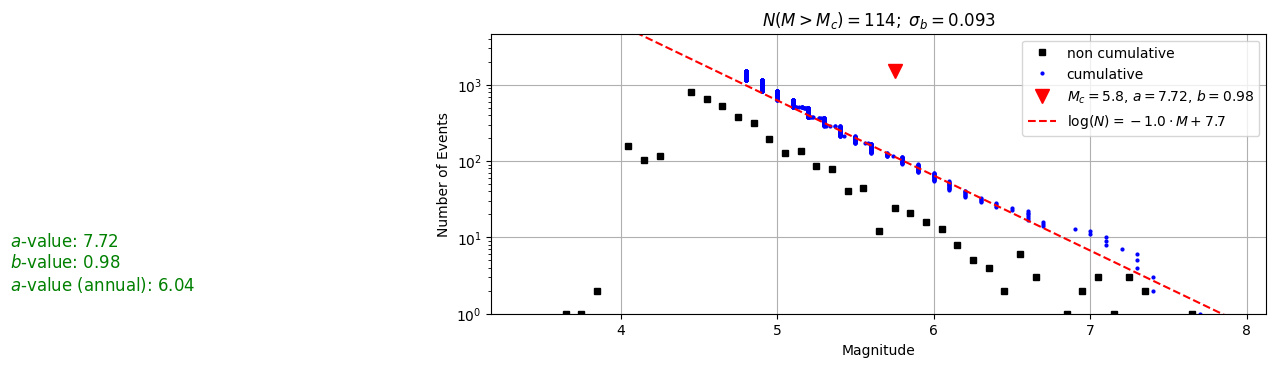

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Langkah 1: Membaca dataset gempa bumi dari URL
datagk = data_selectedgk

# Langkah 2: Mengambil kolom magnitude sebagai input untuk analisis
magnitude_data = datagk['mag'].values

# Langkah 3: Menginstansiasi objek FMD dan memuat data magnitudo
oFMD = FMD()
oFMD.data['mag'] = magnitude_data

# Langkah 4: Menentukan kekompletan (Mc) dan menyesuaikan distribusi gempa bumi
oFMD.mag_dist()
oFMD.get_Mc(mc_type=np.arange(1.5, 6, 0.05))
oFMD.fit_GR(binCorrection=0)

# Langkah 5: Membuat plot distribusi magnitudo
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2, 1, 1)
oFMD.plotFit(ax1)

plt.show()


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Langkah 1: Membaca dataset gempa bumi dari URL
datagk = data_selectedgk

# Langkah 2: Mengambil kolom magnitude sebagai input untuk analisis
magnitude_data = datagk['mag'].values

# Langkah 3: Menginstansiasi objek FMD dan memuat data magnitudo
oFMD = FMD()
oFMD.data['mag'] = magnitude_data

# Langkah 4: Menentukan kekompletan (Mc) dan menyesuaikan distribusi gempa bumi
oFMD.mag_dist()
oFMD.get_Mc(mc_type=np.arange(1.5, 6, 0.05))
oFMD.fit_GR(binCorrection=0)

# Langkah 4: Mendapatkan nilai a-value, b-value, dan a-value (annual)
a_gk = oFMD.par['a']
b_gk = oFMD.par['b']
a_annual_gk = a_gk - np.log10(48)  # Asumsi 48 tahun pengamatan

####**Gruenthal**

$t = \left| e^{-3.95 + (0.62 + 17.32M)^2} \right| : M \geq 6.5: $

$t = 10^{(2.8 + 0.024M)} : M < 6.5 $

$d = e^{(1.77 + (0.037 + 1.02M)^2)} $

In [7]:
import numpy as np
import pandas as pd

class GruenthalMethod:
    def __init__(self):
        pass

    def calculate_time(self, M):
        if M >= 6.5:
            tgr = np.abs(np.exp(-3.95 + (0.62 + 17.32 * M)**2))
        else:
            tgr = 10**(2.8 + 0.024 * M)
        return tgr

    def calculate_distance(self, M):
        dgr = np.exp(1.77 + (0.037 + 1.02 * M)**2)
        return dgr

# Read earthquake data from the provided URL
datagr = merged_df

# Create an instance of the declustering method
declust_methodgr = GruenthalMethod()

# Calculate time and distance for each earthquake event in the dataset
datagr['time_window'] = datagr['mag'].apply(lambda x: declust_methodgr.calculate_time(x))
datagr['distance_window'] = datagr['mag'].apply(lambda x: declust_methodgr.calculate_distance(x))

# Select only the required columns
data_selectedgr = datagr[['time', 'longitude', 'latitude', 'mag', 'magType', 'depth', 'time_window', 'distance_window']]

# Print the first few rows of the modified dataset with selected columns
data_selectedgr.head()


# Drop rows with infinity values in the selected columns
datagr = datagr.replace([np.inf, -np.inf], np.nan).dropna(subset=['time_window', 'distance_window'])

# Select only the required columns
data_selectedgr = datagr[['time', 'longitude', 'latitude', 'mag', 'magType', 'depth', 'time_window', 'distance_window']]

# Print the first few rows of the modified dataset with selected columns
data_selectedgr = datagr.dropna()

data_selectedgr.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,time_window,distance_window
3177,2022-12-31 17:05:40.098000+00:00,33.5482,48.3346,19.314,4.1,mb,29.0,204.0,2.670,0.89,...,earthquake,12.00,6.301,0.145,15.0,reviewed,us,us,791.407205,3.155921e+08
3178,2022-12-28 16:51:24.737000+00:00,27.9530,55.7860,10.000,4.5,mb,83.0,56.0,3.019,0.49,...,earthquake,4.52,1.853,0.072,56.0,reviewed,us,us,809.095899,1.165649e+10
3179,2022-12-25 21:55:42.149000+00:00,28.5611,52.7403,10.000,4.4,mb,20.0,95.0,4.749,0.79,...,earthquake,8.05,1.869,0.203,7.0,reviewed,us,us,804.637002,4.583025e+09
3180,2022-12-25 17:49:57.720000+00:00,34.1297,57.1703,10.000,4.2,mb,49.0,83.0,9.191,0.57,...,earthquake,8.41,1.900,0.118,20.0,reviewed,us,us,795.792790,7.541041e+08
3181,2022-12-25 16:48:43.795000+00:00,28.6564,51.6318,10.000,4.1,mb,20.0,97.0,5.509,0.31,...,earthquake,10.77,1.979,0.157,11.0,reviewed,us,us,791.407205,3.155921e+08


In [8]:
import pandas as pd
import numpy as np

datagr = data_selectedgr

# Fungsi untuk menghitung waktu (t) berdasarkan magnitudo (M) dengan metode Gruenthal
def calculate_time_gruenthal(M):
    if M >= 6.5:
        exponent = -3.95 + (0.62 + 17.32 * M)**2
        tgr = np.abs(np.exp(exponent))
    else:
        tgr = np.power(10, 2.8 + 0.024 * M)  # Updated equation for M < 6.5
    return tgr

# Fungsi untuk menghitung jarak (d) berdasarkan magnitudo (M) dengan metode Gruenthal
def calculate_distance_gruenthal(M):
    exponent = 1.77 + (0.037 + 1.02 * M)**2
    dgr = np.exp(exponent)
    return dgr

# Fungsi untuk mengklasifikasikan event sebagai Mainshock atau Aftershock berdasarkan metode Gruenthal
def classify_event_gruenthal(M, tgr, dgr, method):
    if method == "Gruenthal":
        if M >= 6.5:
            if np.isclose(tgr, np.abs(np.exp(-3.95 + (0.62 + 17.32 * M)**2))) and np.isclose(dgr, np.exp(1.77 + (0.037 + 1.02 * M)**2)):
                return "Mainshock"
            else:
                return "Aftershock"
        else:
            if np.isclose(tgr, np.power(10, 2.8 + 0.024 * M)):  # Updated condition for M < 6.5
                return "Mainshock"
            else:
                return "Aftershock"

# Buat kolom baru untuk waktu (t) dan jarak (d) menggunakan metode Gruenthal
datagr['time_gruenthal'] = datagr['mag'].apply(calculate_time_gruenthal)
datagr['distance_gruenthal'] = datagr['mag'].apply(calculate_distance_gruenthal)

# Hitung jumlah kejadian gempa untuk setiap rentang magnitudo yang ditentukan
magnitudes_ranges = [(4.00, 5.00), (5.01, 6.00), (6.01, 7.00), (7.01, 8.00), (8.00, 8.30)]

mainshock_countsgr = []
aftershock_countsgr = []

for mag_range in magnitudes_ranges:
    mainshock_countgr = datagr[(datagr['mag'] >= mag_range[0]) & (datagr['mag'] <= mag_range[1]) & (datagr.apply(lambda row: classify_event_gruenthal(row['mag'], row['time_gruenthal'], row['distance_gruenthal'], "Gruenthal") == "Mainshock", axis=1))].shape[0]
    aftershock_countgr = datagr[(datagr['mag'] >= mag_range[0]) & (datagr['mag'] <= mag_range[1]) & (datagr.apply(lambda row: classify_event_gruenthal(row['mag'], row['time_gruenthal'], row['distance_gruenthal'], "Gruenthal") == "Aftershock", axis=1))].shape[0]
    mainshock_countsgr.append(mainshock_countgr)
    aftershock_countsgr.append(aftershock_countgr)

# Tampilkan hasil perhitungan dalam bentuk tabel
result_table = pd.DataFrame({
    'Magnitude Range': [f'{mag_range[0]} - {mag_range[1]}' for mag_range in magnitudes_ranges],
    'Mainshock Counts': mainshock_countsgr,
    'Aftershock Counts': aftershock_countsgr
})

result_table

,Magnitude Range,Mainshock Counts,Aftershock Counts
0,4.0 - 5.0,170,0
1,5.01 - 6.0,17,0
2,6.01 - 7.0,0,0
3,7.01 - 8.0,0,0
4,8.0 - 8.3,0,0


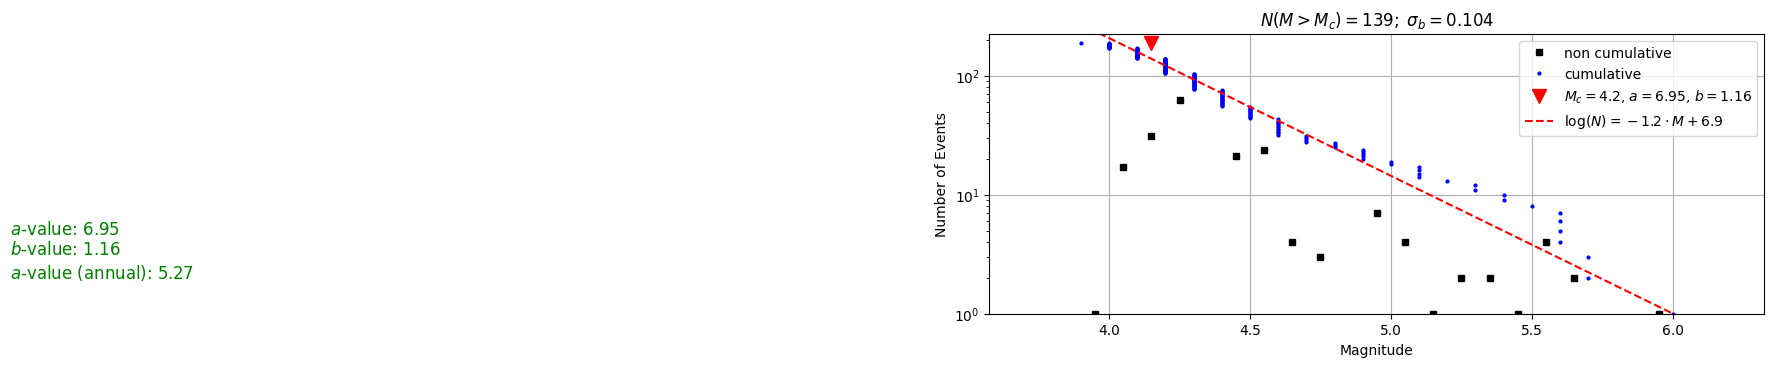

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Langkah 1: Membaca dataset gempa bumi dari URL
datagr = data_selectedgr

# Langkah 2: Mengambil kolom magnitude sebagai input untuk analisis
magnitude_data = datagr['mag'].values

# Langkah 3: Menginstansiasi objek FMD dan memuat data magnitudo
oFMD = FMD()
oFMD.data['mag'] = magnitude_data

# Langkah 4: Menentukan kekompletan (Mc) dan menyesuaikan distribusi gempa bumi
oFMD.mag_dist()
oFMD.get_Mc(mc_type=np.arange(1.5, 6, 0.05))
oFMD.fit_GR(binCorrection=0)

# Langkah 5: Membuat plot distribusi magnitudo
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2, 1, 1)
oFMD.plotFit(ax1)

plt.show()


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Langkah 1: Membaca dataset gempa bumi dari URL
datagr = data_selectedgr

# Langkah 2: Mengambil kolom magnitude sebagai input untuk analisis
magnitude_data = datagr['mag'].values

# Langkah 3: Menginstansiasi objek FMD dan memuat data magnitudo
oFMD = FMD()
oFMD.data['mag'] = magnitude_data

# Langkah 4: Menentukan kekompletan (Mc) dan menyesuaikan distribusi gempa bumi
oFMD.mag_dist()
oFMD.get_Mc(mc_type=np.arange(1.5, 6, 0.05))
oFMD.fit_GR(binCorrection=0)

# Langkah 4: Mendapatkan nilai a-value, b-value, dan a-value (annual)
a_gr = oFMD.par['a']
b_gr = oFMD.par['b']
a_annual_gr = a_gr - np.log10(48)  # Asumsi 48 tahun pengamatan

####**Uhrhammer**

$t = e^{-2.87 + 1.235M}$

$d = e^{-1.024 + 0.804M}$

In [11]:
import numpy as np
import pandas as pd

class UhrhammerMethod:
    def __init__(self):
        pass

    def calculate_time(self, M):
        tuh = np.exp(-2.87 + 1.235 * M)
        return tuh

    def calculate_distance(self, M):
        duh = np.exp(-1.024 + 0.804 * M)
        return duh

# Read earthquake data from the provided DataFrame
datauh = merged_df

# Create an instance of the declustering method
declust_methoduh = UhrhammerMethod()

# Calculate time and distance for each earthquake event in the dataset
datauh['time_window'] = datauh['mag'].apply(declust_methoduh.calculate_time)
datauh['distance_window'] = datauh['mag'].apply(declust_methoduh.calculate_distance)

# Select only the required columns
data_selecteduh = datauh[['time', 'longitude', 'latitude', 'mag', 'magType', 'depth', 'time_window', 'distance_window']]

# Drop rows with missing values
data_selecteduh.dropna(inplace=True)

# Print the first few rows of the modified dataset with selected columns
data_selecteduh.head(10)


<ipython-input-11-e6902902f24d>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selecteduh.dropna(inplace=True)


,time,longitude,latitude,mag,magType,depth,time_window,distance_window
0,1987-12-18 20:54:33.750000+00:00,56.683,28.239,4.6,mb,33.0,16.626536,14.503645
1,1987-12-18 16:24:03.050000+00:00,56.677,28.191,5.9,mw,19.8,82.805957,41.247892
2,1987-11-30 03:12:37+00:00,51.170,30.990,4.8,mb,37.7,21.284945,17.033807
3,1987-11-27 08:26:43.780000+00:00,59.100,32.691,4.7,mb,33.0,18.812095,15.717897
4,1987-11-25 22:53:29.970000+00:00,56.753,28.231,4.5,mb,33.0,14.694893,13.383197
5,1987-11-24 13:15:29.310000+00:00,58.890,32.402,4.6,mb,33.0,16.626536,14.503645
6,1987-11-24 11:23:16.900000+00:00,59.105,32.658,5.3,mw,40.6,39.468386,25.462327
7,1987-11-09 16:43:42.250000+00:00,47.799,32.805,4.9,mb,42.1,24.082851,18.459885
8,1987-11-03 14:26:41.410000+00:00,50.439,28.420,4.6,mb,10.0,16.626536,14.503645
9,1987-10-28 21:47:25.220000+00:00,56.374,27.627,4.7,mb,45.8,18.812095,15.717897


In [12]:
import pandas as pd
import numpy as np

class UhrhammerMethod:
    def __init__(self):
        pass

    def calculate_time(self, M):
        tuh = np.exp(-2.87 + 1.235 * M)
        return tuh

    def calculate_distance(self, M):
        duh = np.exp(-1.024 + 0.804 * M)
        return duh

# Fungsi untuk mengklasifikasikan event sebagai Mainshock atau Aftershock berdasarkan metode Uhrhammer
def classify_event_uhrhammer(M, tuh, duh, method):
    if method == "Uhrhammer":
        mainshock_tuh = np.exp(-2.87 + 1.235 * M)
        mainshock_duh = np.exp(-1.024 + 0.804 * M)
        if np.isclose(tuh, mainshock_tuh) and np.isclose(duh, mainshock_duh):
            return "Mainshock"
        else:
            return "Aftershock"

# Create an instance of the declustering method
declust_methoduh = UhrhammerMethod()

# Contoh penggunaan data atau datauh
datauh = data_selecteduh

# Calculate time and distance for each earthquake event in the dataset
datauh['time_uhrhammer'] = datauh['mag'].apply(declust_methoduh.calculate_time)
datauh['distance_uhrhammer'] = datauh['mag'].apply(declust_methoduh.calculate_distance)

# Hitung jumlah kejadian gempa untuk setiap rentang magnitudo yang ditentukan
magnitudes_ranges = [(4.00, 5.00), (5.01, 6.00), (6.01, 7.00), (7.01, 8.00), (8.01, 8.30)]

mainshock_countsuh = []
aftershock_countsuh = []

for mag_range in magnitudes_ranges:
    mainshock_countuh = datauh[(datauh['mag'] >= mag_range[0]) & (datauh['mag'] <= mag_range[1]) & (datauh.apply(lambda row: classify_event_uhrhammer(row['mag'], row['time_uhrhammer'], row['distance_uhrhammer'], "Uhrhammer") == "Mainshock", axis=1))].shape[0]
    aftershock_countuh = datauh[(datauh['mag'] >= mag_range[0]) & (datauh['mag'] <= mag_range[1]) & (datauh.apply(lambda row: classify_event_uhrhammer(row['mag'], row['time_uhrhammer'], row['distance_uhrhammer'], "Uhrhammer") == "Aftershock", axis=1))].shape[0]
    mainshock_countsuh.append(mainshock_countuh)
    aftershock_countsuh.append(aftershock_countuh)

# Tampilkan hasil perhitungan dalam bentuk tabel
result_table = pd.DataFrame({
    'Magnitude Range': [f'{mag_range[0]} - {mag_range[1]}' for mag_range in magnitudes_ranges],
    'Mainshock Counts': mainshock_countsuh,
    'Aftershock Counts': aftershock_countsuh
})

result_table


<ipython-input-12-a7b655f6792d>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datauh['time_uhrhammer'] = datauh['mag'].apply(declust_methoduh.calculate_time)
<ipython-input-12-a7b655f6792d>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datauh['distance_uhrhammer'] = datauh['mag'].apply(declust_methoduh.calculate_distance)


,Magnitude Range,Mainshock Counts,Aftershock Counts
0,4.0 - 5.0,3238,0
1,5.01 - 6.0,583,0
2,6.01 - 7.0,44,0
3,7.01 - 8.0,10,0
4,8.01 - 8.3,0,0


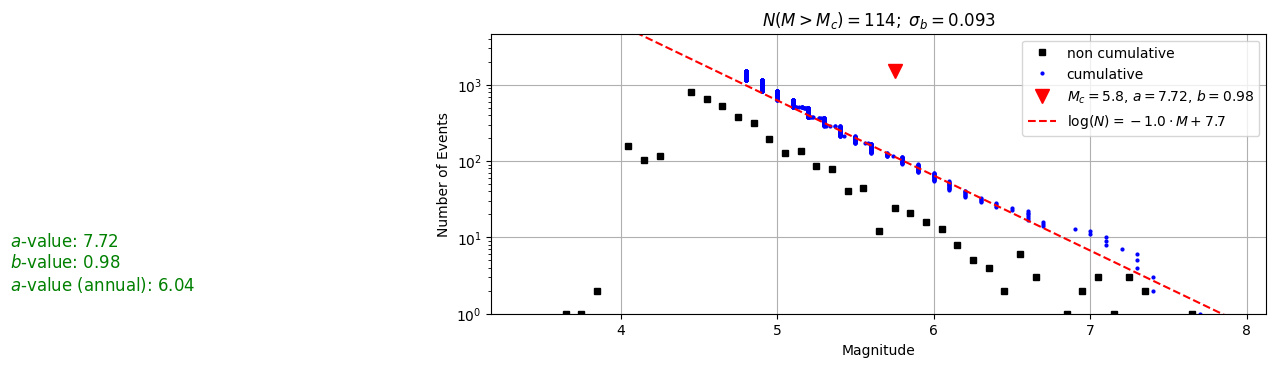

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Langkah 1: Membaca dataset gempa bumi dari URL
datauh = data_selecteduh

# Langkah 2: Mengambil kolom magnitude sebagai input untuk analisis
magnitude_data = datauh['mag'].values

# Langkah 3: Menginstansiasi objek FMD dan memuat data magnitudo
oFMD = FMD()
oFMD.data['mag'] = magnitude_data

# Langkah 4: Menentukan kekompletan (Mc) dan menyesuaikan distribusi gempa bumi
oFMD.mag_dist()
oFMD.get_Mc(mc_type=np.arange(1.5, 6, 0.05))
oFMD.fit_GR(binCorrection=0)

# Langkah 5: Membuat plot distribusi magnitudo
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2, 1, 1)
oFMD.plotFit(ax1)

plt.show()


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Langkah 1: Membaca dataset gempa bumi dari URL
datauh = data_selecteduh

# Langkah 2: Mengambil kolom magnitude sebagai input untuk analisis
magnitude_data = datauh['mag'].values

# Langkah 3: Menginstansiasi objek FMD dan memuat data magnitudo
oFMD = FMD()
oFMD.data['mag'] = magnitude_data

# Langkah 4: Menentukan kekompletan (Mc) dan menyesuaikan distribusi gempa bumi
oFMD.mag_dist()
oFMD.get_Mc(mc_type=np.arange(1.5, 6, 0.05))
oFMD.fit_GR(binCorrection=0)

# Langkah 4: Mendapatkan nilai a-value, b-value, dan a-value (annual)
a_uh = oFMD.par['a']
b_uh = oFMD.par['b']
a_annual_uh = a_uh - np.log10(52)  # Asumsi 48 tahun pengamatan

####**Statistical Method**

In [15]:
import pandas as pd

# Membaca data gempa bumi
earthquake_data = merged_df

# Mengkonversi kolom 'time' dan 'mag' menjadi tipe data numerik
earthquake_data['time'] = pd.to_numeric(earthquake_data['time'], errors='coerce')
earthquake_data['mag'] = pd.to_numeric(earthquake_data['mag'], errors='coerce')

# Mendefinisikan rentang magnitudo
magnitude_ranges = [(4.0, 5.0), (5.01, 6.0), (6.01, 7.0), (7.01, 8.0), (8.01, 8.3)]

# Fungsi untuk mengidentifikasi mainshock dan aftershock berdasarkan rentang magnitudo
def identify_mainshocks_and_aftershocks(earthquake_data, mag_range):
    mainshock_count = 0
    aftershock_count = 0

    # Mengurutkan data berdasarkan waktu
    earthquake_data = earthquake_data.sort_values(by='time')

    for i in range(1, len(earthquake_data)):
        mag = earthquake_data.iloc[i]['mag']
        time_diff = earthquake_data.iloc[i]['time'] - earthquake_data.iloc[i-1]['time']
        mag_diff = abs(earthquake_data.iloc[i]['mag'] - earthquake_data.iloc[i-1]['mag'])

        if mag_range[0] <= mag <= mag_range[1]:
            if time_diff < 3 and mag_diff < 2:
                aftershock_count += 1
            else:
                mainshock_count += 1

    return mainshock_count, aftershock_count

# Menghitung jumlah mainshock dan aftershock untuk setiap rentang magnitudo
mainshock_countstats = []
aftershock_countstats = []

for mag_range in magnitude_ranges:
    mainshock_count, aftershock_count = identify_mainshocks_and_aftershocks(earthquake_data, mag_range)
    mainshock_countstats.append(mainshock_count)
    aftershock_countstats.append(aftershock_count)

# Menampilkan hasil dalam bentuk DataFrame
results_df = pd.DataFrame({
    'Magnitude Range': [f'{mag_range[0]} - {mag_range[1]}' for mag_range in magnitude_ranges],
    'Mainshock Count': mainshock_countstats,
    'Aftershock Count': aftershock_countstats
})

results_df.head()

,Magnitude Range,Mainshock Count,Aftershock Count
0,4.0 - 5.0,3238,0
1,5.01 - 6.0,582,0
2,6.01 - 7.0,44,0
3,7.01 - 8.0,10,0
4,8.01 - 8.3,0,0


##**Conclusion**

In [16]:
from tabulate import tabulate

# Data untuk tabel
# Data untuk tabel
data = [
    ["Gruenthal (1985)", mainshock_countsgr[0], mainshock_countsgr[1], mainshock_countsgr[2], mainshock_countsgr[3], mainshock_countsgr[4]],
    ["Uhrhammer (1986)", mainshock_countsuh[0], mainshock_countsuh[1], mainshock_countsuh[2], mainshock_countsuh[3], mainshock_countsuh[4]],
    ["Gardner-Knopoff (1974)", mainshock_countsgk[0], mainshock_countsgk[1], mainshock_countsgk[2], mainshock_countsgk[3], mainshock_countsgk[4]],
    ["Statistical Methods", mainshock_countstats[0], mainshock_countstats[1], mainshock_countstats[2], mainshock_countstats[3], mainshock_countstats[4]]
]

headers = ["Declustering Method", "4.00-5.00", "5.01-6.00", "6.01-7.00", "7.01-8.00", "8.00-8.30"]

# Mencetak tabel
print(tabulate(data, headers=headers, tablefmt="grid"))


+------------------------+-------------+-------------+-------------+-------------+-------------+
| Declustering Method    |   4.00-5.00 |   5.01-6.00 |   6.01-7.00 |   7.01-8.00 |   8.00-8.30 |
+========================+=============+=============+=============+=============+=============+
| Gruenthal (1985)       |         170 |          17 |           0 |           0 |           0 |
+------------------------+-------------+-------------+-------------+-------------+-------------+
| Uhrhammer (1986)       |        3238 |         583 |          44 |          10 |           0 |
+------------------------+-------------+-------------+-------------+-------------+-------------+
| Gardner-Knopoff (1974) |        3238 |         583 |          44 |          10 |           0 |
+------------------------+-------------+-------------+-------------+-------------+-------------+
| Statistical Methods    |        3238 |         582 |          44 |          10 |           0 |
+------------------------+----

In [17]:
from tabulate import tabulate

# Data untuk tabel
# Data untuk tabel
data = [
    ["Gruenthal (1985)", a_gr, b_gr, a_annual_gr],
    ["Uhrhammer (1986)", a_uh, b_uh, a_annual_uh],
    ["Gardner-Knopoff (1974)", a_gk, b_gk, a_annual_gk]
]

headers = ["Declustering Method", "a-value", "b-value","a-value (annual)"]

# Mencetak tabel
print(tabulate(data, headers=headers, tablefmt="grid"))

+------------------------+-----------+-----------+--------------------+
| Declustering Method    |   a-value |   b-value |   a-value (annual) |
+========================+===========+===========+====================+
| Gruenthal (1985)       |   6.9469  |  1.15756  |            5.26566 |
+------------------------+-----------+-----------+--------------------+
| Uhrhammer (1986)       |   7.71655 |  0.984286 |            6.00054 |
+------------------------+-----------+-----------+--------------------+
| Gardner-Knopoff (1974) |   7.71655 |  0.984286 |            6.03531 |
+------------------------+-----------+-----------+--------------------+
